In [74]:
%matplotlib notebook
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from importlib import import_module, reload
import sys
add_to_path = lambda f: sys.path.append(f) 

In [34]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color'] # store color array\

In [84]:
eg = import_module('SpringMassDamper')
DMD = import_module('DMD')
delay_embed = getattr(DMD, 'delay_embed')

In [85]:
eg = reload(eg)
DMD = reload(DMD)

# Sine example

Here we show off the importance of delay embeddings.

If a real-valued operator A doesn't have sufficient dimensionality, then it cannot produce the necessary complex conjugate pair of roots required to produce oscillatory time dynamics. For example, suppose we are measuring a 1D sine wave. The DMD operator A would have only one real root. The operator must be augmented to capture the oscillation.

<IPython.core.display.Javascript object>


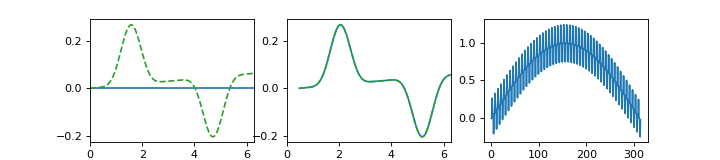

<IPython.core.display.Javascript object>


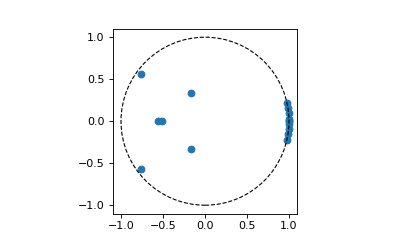

In [94]:
fig, axes = plt.subplots(1, 3, figsize=[9,2])

ts = np.linspace(0,2*np.pi, 200)
data = np.sin(1e-2*ts) + 0.25*np.sin(ts)**7 # powers -> add'l freq for each extra power
data = data.reshape(1,-1)

# 1 - Regular DMD
dmd = DMD.DMD(data, ts)
axes[0].plot(ts, dmd.predict(ts)[0].real, c=color[0])
axes[0].plot(dmd.orig_timesteps, dmd.X1[0], ls='--', c=color[2])
axes[0].set_xlim([0,2*np.pi])

# 2- Delay embed
shift = 15 # shift + 1 is number of eigenvalues (2*7 + 2)
ts1 = ts[shift:]
dmd = DMD.DMD(delay_embed(data, shift), ts[shift:])

axes[1].plot(ts1, dmd.predict(ts1)[0].real, c=color[0])
axes[1].plot(dmd.orig_timesteps, dmd.X1[0], ls='--', c=color[2])
axes[1].set_xlim([0,2*np.pi])

# plot long times (captures low frequency, too)
ts = np.linspace(ts1[0],1e2*np.pi, 1000)
axes[2].plot(ts, dmd.predict(ts)[0].real, c=color[0])

# toss in an eigenvalue plot at the end
DMD.plot_eigs(dmd.eigs, figsize=[5,3]);

# Spring-Mass-Damper example

We'll show how DMD works with a physical system where we have intuition for forcing.

In [8]:
# Initialize system
smd = eg.spring_mass_damper({'mass': 10, 'spring': 1, 'damper': 1})
y0 = np.array([0, 2]) # kick it

# Choose times (these are universally used throughout this section for the control pulse)
t_span = [0,100]
dt = .1
ts = np.linspace(*t_span, 1000)

First, compute the transfer function for a linear state space system under forcing. We'll plot the transfer function to find interesting frequencies by inspection

<IPython.core.display.Javascript object>


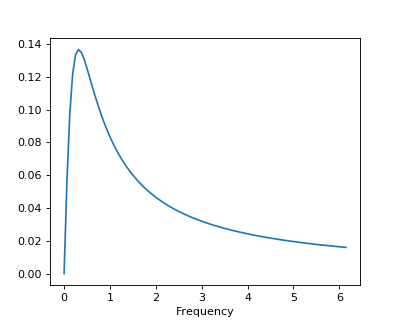

<IPython.core.display.Javascript object>


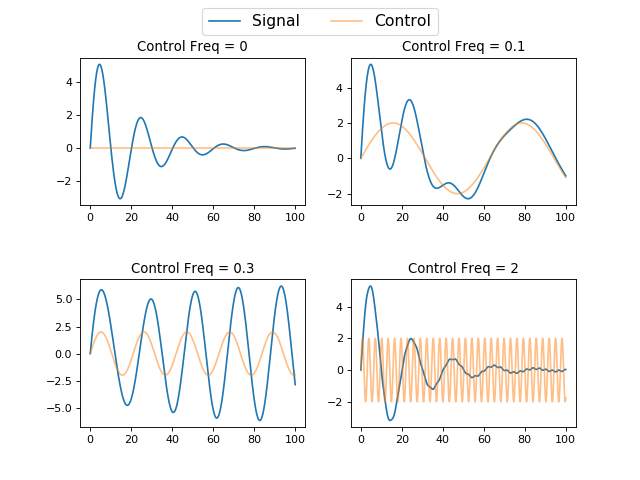

In [14]:
# Transfer function for a linear state space system
G = lambda s: np.linalg.inv(s%(2*np.pi)*np.identity(2)-smd.A)@smd.B

fig, ax = plt.subplots(1, figsize=[5,4])
freq = np.linspace(0, 43/7, 100)
ax.plot(freq, [G(s)[1] for s in freq])
ax.set_xlabel('Frequency')

# Plot some frequencies
fig, axes = plt.subplots(2,2,figsize=[8,6])
fig.subplots_adjust(hspace=.5)
for ax, freq in zip(axes.flatten(), [0,.1,.3,2]):
    # Run simulation
    smd.set_control(ts, 2*np.sin(freq*ts))
    res = smd.simulate(y0, t_span, dt, True)
    
    # Plot result
    ax.set_title('Control Freq = {}'.format(freq))
    ax.plot(smd.t, smd.x)
    ax.plot(smd.t, smd.u(smd.t), alpha=0.5)
    
fig.legend(['Signal', 'Control'], fontsize=14, loc='upper center', ncol=2)

Let's look at the SMD without any external forcing. This example will show how time delays are similar to including a measured derivative term.

<IPython.core.display.Javascript object>


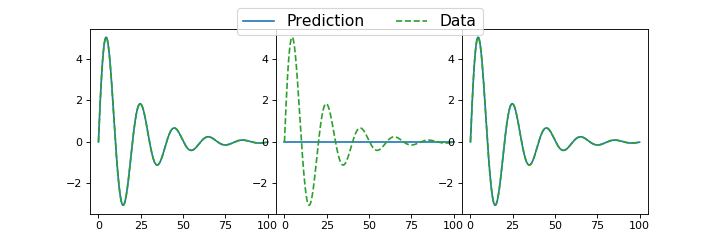

In [69]:
fig, axes = plt.subplots(1,3, figsize=[9,3])
fig.subplots_adjust(wspace=0)

omega = 0 # no control
smd.set_control(ts, 2*np.sin(omega*ts))
res = smd.simulate(y0, t_span, dt, True)

# Default
dmd = DMD.DMD(res.y, res.t)
axes[0].plot(dmd.orig_timesteps, dmd.predict()[0].real, c=color[0])
axes[0].plot(dmd.orig_timesteps, dmd.X1[0], ls='--', c=color[2])

# Only measure x:
dmd = DMD.DMD(res.y[0,:].reshape(1,-1), res.t)
axes[1].plot(dmd.orig_timesteps, dmd.predict()[0].real, c=color[0])
axes[1].plot(dmd.orig_timesteps, dmd.X1[0], ls='--', c=color[2])

# Only measure x and time-delay
s = 2
dmd = DMD.DMD(delay_embed(res.y[0,:].reshape(1,-1), s), res.t[2:])
axes[2].plot(dmd.orig_timesteps, dmd.predict()[0].real, c=color[0])
axes[2].plot(dmd.orig_timesteps, dmd.X1[0], ls='--', c=color[2])

fig.legend(['Prediction', 'Data'], fontsize=14, loc='upper center', ncol=2)

Next, let's just inspect an example where the control is nonlinear. Can we capture the dynamics with regular DMD? Yes, if we time-delay enough.

<IPython.core.display.Javascript object>


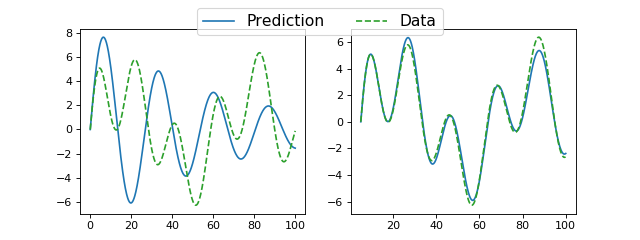

In [71]:
smd.set_control(ts, 4*np.sin(0.1*ts)**3) # weird non-linear forcing
res = smd.simulate(y0, t_span, dt, True)

fig, axes = plt.subplots(1,2,figsize=[8,3])
dmd = DMD.DMD(res.y, res.t)
# Ironically, the best fit linear operator looks like the underlying dynamics.
axes[0].plot(dmd.orig_timesteps, dmd.predict()[0].real, c=color[0])
axes[0].plot(dmd.orig_timesteps, dmd.X1[0], ls='--', c=color[2])

# Delay embed to capture extra control frequencies? Needs a bunch...
s = 50
dmd = DMD.DMD(delay_embed(res.y, s), res.t[s:])
axes[1].plot(ts[s:], dmd.predict(ts[s:])[0].real, c=color[0])
axes[1].plot(dmd.orig_timesteps, dmd.X1[0], ls='--', c=color[2])

fig.legend(['Prediction', 'Data'], fontsize=14, loc='upper center', ncol=2)

Now let's have DMDc go to work on the same data. No time-delays needed and we get the underlying dynamics. Compare this result to the previous one without DMDc.

<IPython.core.display.Javascript object>


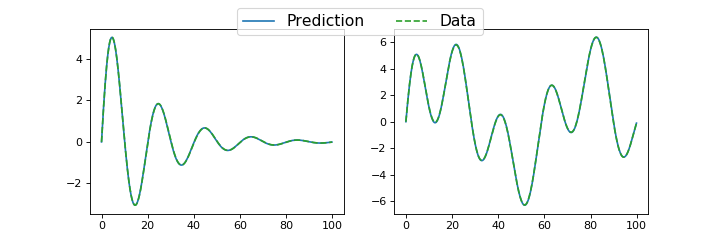

Equal dynamics? True


In [87]:
fig, axes = plt.subplots(1,2,figsize=[9,3])

Ups = (4*np.sin(0.1*ts)**3).reshape(1,-1) # weird non-linear forcing
smd.set_control(ts, Ups)
res = smd.simulate(y0, t_span, dt, True)
X = res.y

dmdc = DMD.DMDc(X, Ups, ts)
axes[1].plot(dmdc.orig_timesteps, dmdc.predict()[0,:],  c=dmdc.color[0])
axes[1].plot(dmdc.orig_timesteps, dmdc.X1[0,:], ls='--', c=dmdc.color[2])

smd.set_control(ts, np.zeros_like(ts))
res0 = smd.simulate(y0, t_span, dt, True)
axes[0].plot(dmdc.orig_timesteps, dmdc.predict(dmdc.zero_control())[0,:].real, c=dmdc.color[0])
axes[0].plot(res0.t, res0.y[0,:], ls='--', c=dmdc.color[2]) # NOTE: fictituous offset for visibility

fig.legend(['Prediction', 'Data'], fontsize=14, loc='upper center', ncol=2)
print('Equal dynamics? ' + str(np.allclose(dmdc.A, sp.linalg.expm(smd.A*dt), atol=1e-3)))

# TODO: Threshold example